You may face some of the following problems when using the official [Insightface](https://github.com/deepinsight/insightface) library for face detection and embedding:
1. The server you are using has a very low version of glibc (such as 2.17) and high version of CUDA (such as 12.0), while onnxruntime-gpu does not support both versions simultaneously.
2. The detection of Insightface library sometimes fails due to factors such as the face occupying almost the entire image.
3. The Insightface library is not accurate for age estimation, or you need you more functionality but don't want to use two libraries.

Then you can migrate from Insightface to Facexlib as follows.

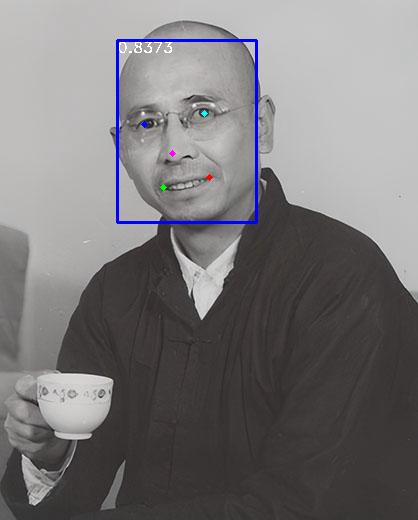

In [1]:
# migrate detection and recognition without changing model

import cv2
import os

import torch

# if your network is stable, set this to enable automatic downloading when first using the model
os.environ['BLOCK_DOWNLOADING'] = 'false'

from facexlib.detection import init_detection_model
from facexlib.recognition import init_recognition_model, norm_crop
from facexlib.visualization import visualize_detection

# initialize detection and recognition models
det_net = init_detection_model('insight_retina')
recog_net = init_recognition_model('antelopev2')

# load image and detect
img = cv2.imread('../assets/test.jpg')

with torch.no_grad():
    bboxes = det_net.detect_faces(img)
    
    # crop and get embedding
    img_crop = norm_crop(img, bboxes[0][5:])
    embedding = recog_net.get_feat(img_crop)[0].cpu().numpy()

visualize_detection(img, bboxes)

In [2]:
# check result using insightface

import numpy as np
from insightface.app import FaceAnalysis
from facexlib.recognition import calculate_sim

app = FaceAnalysis('antelopev2', allowed_modules=['detection', 'recognition'])
app.prepare(ctx_id=0, det_size=(640, 640))
embedding_gt = app.get(img)[0].embedding

degree = np.arccos(calculate_sim(embedding_gt, embedding)) / np.pi * 180
max_diff = np.max(np.abs(embedding_gt - embedding)) / np.linalg.norm(embedding_gt) * 100
print(f'The difference between two results is {degree:.4f} degrees, max difference is {max_diff:.2f}% percent.')

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ../inference/insightface\models\antelopev2\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ../inference/insightface\models\antelopev2\2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: ../inference/insightface\models\antelopev2\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../inference/insightface\models\antelopev2\glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ../inference/insightface\models\antelopev2\scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)
The difference between two results is 0.3045 degree